# CAMERA Workshop 2019

Lawrence Berkeley National Laboratory - LBNL

* Support material for the tutorial _Image processing for microCT using scikit-image (Part I)_.

This tutorial will introduce how to analyze three dimensional stacked and volumetric
images in Python, mainly using scikit-image. Here we will learn how to:
  * pre-process data using filtering, binarization and segmentation techniques.
  * inspect, count and measure attributes of objects and regions of interest in the data.
  * visualize 3D data.

Please prepare for the tutorial by [installing the pre-requisite software](preparation.md) beforehand.

For more info:
  * [[CAMERA Workshop 2019]](http://microct.lbl.gov/cameratomo2019/)
  * [[scikit-image]](https://scikit-image.org/)


## What is scikit-image?

scikit-image is a collection of image processing algorithms which aims to integrate well with for the SciPy ecosystem.

It is well documented, and provides well-tested code to quickly build sophisticated image processing pipelines.


## Importing the base Scientific Python ecossystem

Let's start importing the basics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage

%matplotlib inline

## Importing some helping functions

In [2]:
import supplementary_code as sc

Then, let's set a nice, `monospace` font for matplotlib's figures.

In [3]:
plt.rcParams['font.family'] = 'monospace'

## Introduction to two-dimensional image processing

In scikit-image, images are represented as `numpy` arrays.

A grayscale image is a 2D matrix of pixel intensities of shape `(row, column)`. They are also called single-channel images. Multi-channel data has an extra dimension, `channel`, in the final position. `channel` contains color information:

|Image type|Coordinates|
|:---|:---|
|2D grayscale|(row, column)|
|2D multichannel|(row, column, channel)|


## [skimage.io](https://scikit-image.org/docs/stable/api/skimage.io.html) - utilities to read and write images in several formats<a id='io'></a>

This module helps us on reading images and saving the results. There are multiple plugins available, which support multiple formats. The most commonly used functions include:

* `io.imread`: read an image to a numpy array.
* `io.imsave`: write an image to disk.
* `io.imread_collection`: read multiple images which match a common pattern.

In [4]:
from skimage import io  # skimage's I/O submodule.

Data can be loaded with `io.imread`, as in the following example.

In [5]:
cells = io.imread('../data/cells.tif')

First let's check its shape, data type and range.

In [6]:
print('* "cells" shape: {}'.format(cells.shape))
print('* "cells" type: {}'.format(cells.dtype))
print('* "cells" range: {}, {}'.format(cells.min(), cells.max()))

* "cells" shape: (60, 256, 256)
* "cells" type: float64
* "cells" range: 0.0, 1.0


We see that `cells` has 60 planes, each with 256 rows and 256 columns. Let's focus here on processing one of the planes first, which falls to the case of processing a two-dimensional image. Then, we can visualize a 2D plane using `skimage.io.imshow`.

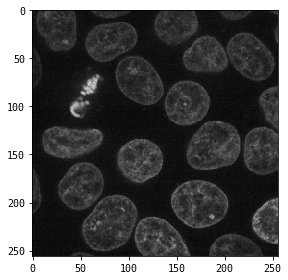

In [7]:
plane = cells[32]  # using the plane 32
io.imshow(plane, cmap='gray')

Note that `skimage.io.imshow` can only display grayscale and RGB(A) 2D images.

## [skimage.exposure](https://scikit-image.org/docs/stable/api/skimage.exposure.html) - evaluating or changing the exposure of an image<a id='exposure'></a>

This module contains a number of functions for adjusting image contrast. We will use `exposure.adjust_gamma`, which performs gamma correction in the input image.


[Gamma correction](https://en.wikipedia.org/wiki/Gamma_correction), also known as Power Law Transform, brightens or darkens an image. The function $O = I^\gamma$ is applied to each pixel in the image. A `gamma < 1` will brighten an image, while a `gamma > 1` will darken an image.

In [8]:
from skimage import exposure  # skimage's exposure module.

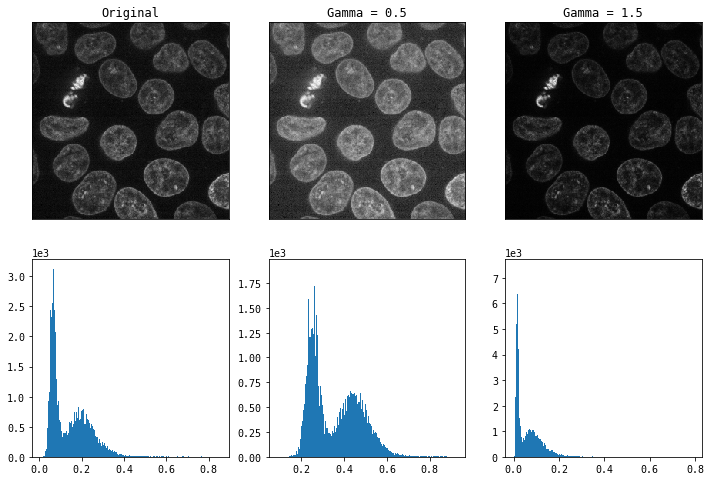

In [9]:
gamma_val_low = 0.5
plane_gamma_low = exposure.adjust_gamma(plane, gamma=gamma_val_low)

gamma_val_high = 1.5
plane_gamma_high = exposure.adjust_gamma(plane, gamma=gamma_val_high)

_, ((win_top_left, win_top_center, win_top_right),
    (win_bottom_left, win_bottom_center, win_bottom_right)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Original and its histogram.
sc.show_plane(win_top_left, plane, title='Original')
sc.plot_hist(win_bottom_left, plane)

# Gamma = 0.5 and its histogram.
sc.show_plane(win_top_center, plane_gamma_low, title='Gamma = {}'.format(gamma_val_low))
sc.plot_hist(win_bottom_center, plane_gamma_low)

# Gamma = 1.5 and its histogram.
sc.show_plane(win_top_right, plane_gamma_high, title='Gamma = {}'.format(gamma_val_high))
sc.plot_hist(win_bottom_right, plane_gamma_high)

Most experimental images are affected by salt and pepper noise. A few bright artifacts can decrease the relative intensity of the pixels of interest.

A simple way to improve contrast is to clip the pixel values on the lowest and highest extremes. Here we use `exposure.rescale_intensity` for that. Clipping the darkest and brightest 0.5% of pixels will increase the overall contrast of the image.

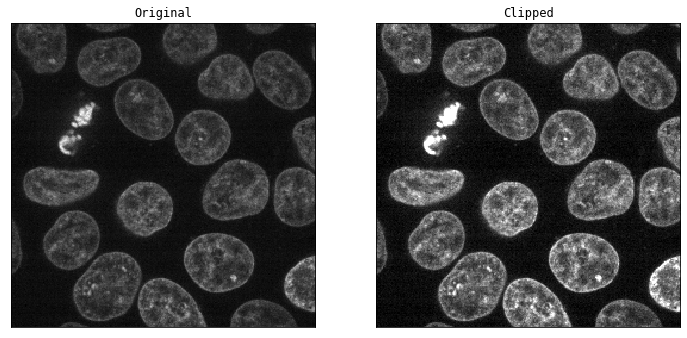

In [10]:
vmin, vmax = np.percentile(plane, q=(0.5, 99.5))

plane_clipped = exposure.rescale_intensity(
    plane,
    in_range=(vmin, vmax), 
    out_range=np.float32
)

# Checking the results.
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane, title='Original');
sc.show_plane(win_right, plane_clipped, title='Clipped');

We'll call our dataset `plane_rescaled` from now on. It will contain the plane version with clipped data.

In [11]:
plane_rescaled = plane_clipped

<div class="alert alert-success">

__Exercise: <font color='red'>(⏰ 5 min)</font>__ One of the most common tools to evaluate exposure is the *histogram*, which plots the number of points which have a certain value against the values in order from lowest (dark) to highest (light).

A well-known tool for that is the [Histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization), which improves contrast in an image by redistributing pixel intensities. This operation may enhance background noise, since the most common pixel intensities are spread out, allowing areas of lower local contrast to gain a higher contrast. 

[Adaptive histogram equalization](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization), on the other hand, is suitable for improving the local contrast and enhancing the definitions of edges in each region of an image. The adaptive method computes several histograms, each corresponding to a section of the image, and uses them to redistribute its lightness values. 

Now, there's some tasks for you:
  * Process `plane`'s histogram using histogram equalization, given in `exposure.equalize_hist`, and its adaptive version, from `exposure.equalize_adapthist`.
  * Visualize the results.

In [12]:
# Your solution goes here!

# First, let's create a version using histogram equalization. 
plane_equalized = exposure.equalize_hist(...)

# Now, a version using CLAHE. 
plane_clahe = exposure.equalize_adapthist(...)

# Let's check the results.
_, ((win_top_left, win_top_center, win_top_right),
    (win_bottom_left, win_bottom_center, win_bottom_right)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# On the top, the 2D plots...
sc.show_plane(win_top_left, ..., title='Original')
sc.show_plane(win_top_center, ..., title='Histogram equalization')
sc.show_plane(win_top_right, ..., title='CLAHE')

# ... on the bottom, the histograms.
sc.plot_hist(win_bottom_left, ...)
sc.plot_hist(win_bottom_center, ...)
sc.plot_hist(win_bottom_right, ...)

AttributeError: 'ellipsis' object has no attribute 'shape'

## Edge detection

[Edge detection](https://en.wikipedia.org/wiki/Edge_detection) highlights regions in the image where a sharp change in contrast occurs. The intensity of an edge corresponds to the steepness of the transition from one intensity to another. A gradual shift from bright to dark intensity results in a dim edge. An abrupt shift results in a bright edge.

## [skimage.filters](https://scikit-image.org/docs/stable/api/skimage.filters.html) - apply filters to an image<a id='filters'></a>

Filtering applies whole-image modifications such as sharpening or blurring. In addition to edge detection, `skimage.filters` provides functions for filtering and thresholding images.

Notable functions include (links to relevant gallery examples):

* [Thresholding](https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding.html):
  * `filters.threshold_*` (multiple different functions with this prefix)
  * `filters.try_all_threshold` to compare various methods
* [Edge finding/enhancement](https://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html):
  * `filters.sobel` - not adapted for 3D images. It can be applied planewise to approximate a 3D result.
  * `filters.prewitt`
  * `filters.scharr`
  * `filters.roberts`
  * `filters.laplace`
  * `filters.hessian`
* [Ridge filters](https://scikit-image.org/docs/stable/auto_examples/edges/plot_ridge_filter.html):
  * `filters.meijering`
  * `filters.sato`
  * `filters.frangi`
* Inverse filtering (see also [skimage.restoration](#restoration)):
  * `filters.weiner`
  * `filters.inverse`
* [Directional](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_gabor.html): `filters.gabor`
* Blurring/denoising
  * `filters.gaussian`
  * `filters.median`
* [Sharpening](https://scikit-image.org/docs/stable/auto_examples/filters/plot_unsharp_mask.html): `filters.unsharp_mask`
* Define your own filter: `LPIFilter2D`
  
The sub-submodule `skimage.filters.rank` contains rank filters. These filters are nonlinear and operate on the local histogram.

In [13]:
from skimage import filters  # skimage's filtering module

The [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) is an edge detection algorithm which approximates the gradient of the image intensity, and is fast to compute.

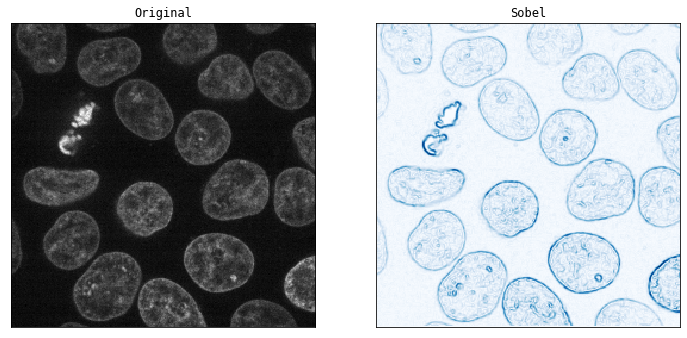

In [14]:
plane_sobel = filters.sobel(plane_rescaled)

# Checking the results.
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane, title='Original');
# setting a different map to ease visualization
sc.show_plane(win_right, plane_sobel, title='Sobel', cmap='Blues');

<div class="alert alert-success">

__Exercise: <font color='red'>(⏰ 5 min)</font>__ let's check the results of other filters.

Your tasks right now are:
  * Try the horizontal (`filters.sobel_h`) and vertical(`filters.sobel_v`) versions of the Sobel filter.
  * Check the results of other filters, `filters.roberts`, `filters.prewitt`, `filters.scharr`.

TypeError: Image data of dtype object cannot be converted to float

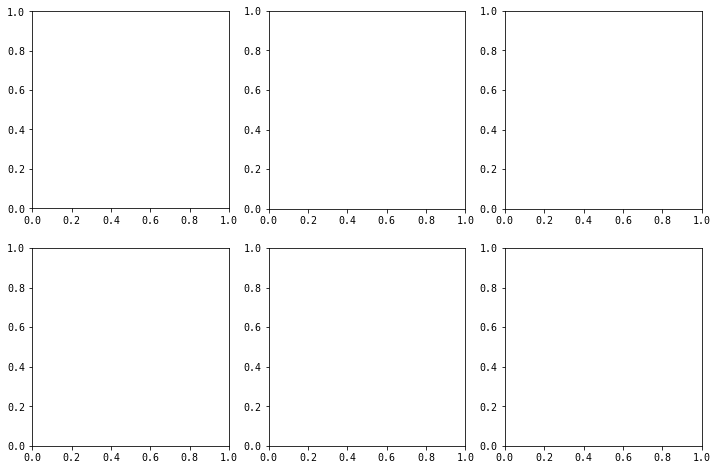

In [15]:
# Your solution goes here!
plane_sobel_h = ...  # Horizontal Sobel.
plane_sobel_v = ...  # Vertical Sobel.
plane_roberts = ...  # Roberts.
plane_prewitt = ...  # Prewitt.
plane_scharr = ...  # Scharr.

# Checking the results.
_, ((win_top_left, win_top_center, win_top_right),
    (win_bottom_left, win_bottom_center, win_bottom_right)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

sc.show_plane(win_top_left, ..., title='Original')
sc.show_plane(win_top_center, ..., title='Horizontal Sobel')
sc.show_plane(win_top_right, ..., title='Vertical Sobel')

sc.show_plane(win_bottom_left, ..., title='Roberts')
sc.show_plane(win_bottom_center, ..., title='Prewitt')
sc.show_plane(win_bottom_right, ..., title='Scharr')

## Filters

[Gaussian filter](https://en.wikipedia.org/wiki/Gaussian_filter) applies a Gaussian function to an image, creating a smoothing effect. `skimage.filters.gaussian` takes as input `sigma` which can be a scalar or a sequence of scalar. This `sigma` determines the standard deviation of the Gaussian along each axis.

In [ ]:
sigma = 1.5

plane_gaussian = filters.gaussian(plane_rescaled,
                                  multichannel=False,
                                  sigma=sigma)

_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane, title='Original');
sc.show_plane(win_right, plane_gaussian, title='Gaussian');

[Median filter](https://en.wikipedia.org/wiki/Median_filter) is a noise removal filter. It is particularly effective against salt and pepper noise. An additional feature of the median filter is its ability to preserve edges. This is helpful in segmentation because the original shape of regions of interest will be preserved.

`skimage.filters.median` does not support three-dimensional images and needs to be applied planewise.

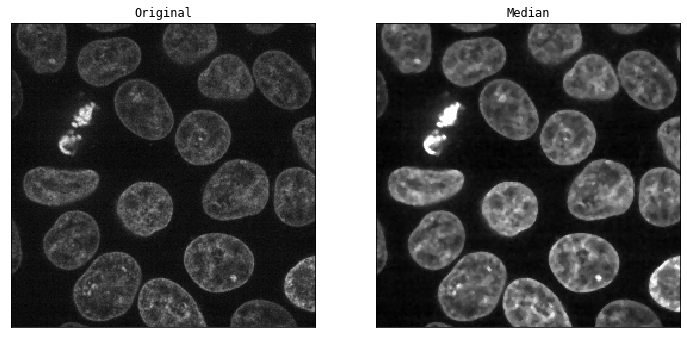

In [19]:
plane_median = filters.median(plane_rescaled, behavior='ndimage')

# Checking the results.
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane, title='Original');
sc.show_plane(win_right, plane_median, title='Median');

We will choose the median-filtered image to continue.

In [20]:
plane_denoised = plane_median

<div class="alert alert-success">

__Exercise: <font color='red'>(⏰ 5 min)</font>__ the module `skimage.restoration` includes routines to restore images and reduce their noise.

Now your tasks are:
  * Use bilateral and Chambolle's total variation filters on the test image. They are in the functions `restoration.denoise_bilateral` and `restoration.denoise_tv_chambolle`, respectively.

In [21]:
from skimage import restoration  # skimage's restoration submodule.

plane_bilateral = restoration. ...
plane_wiener = restoration. ...

# Checking the results.
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

sc.show_plane(win_left, ..., title='Original')
sc.show_plane(win_center, ..., title='Bilateral')
sc.show_plane(win_right, ..., title='TV Chambolle')

SyntaxError: invalid syntax (<ipython-input-21-32dd4f3a27d7>, line 3)

## Thresholding

[Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to create binary images. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker. Thresholding is a form of image segmentation, and different thresholding algorithms produce different results.

Let's try the Li's minimum cross entropy threshold:

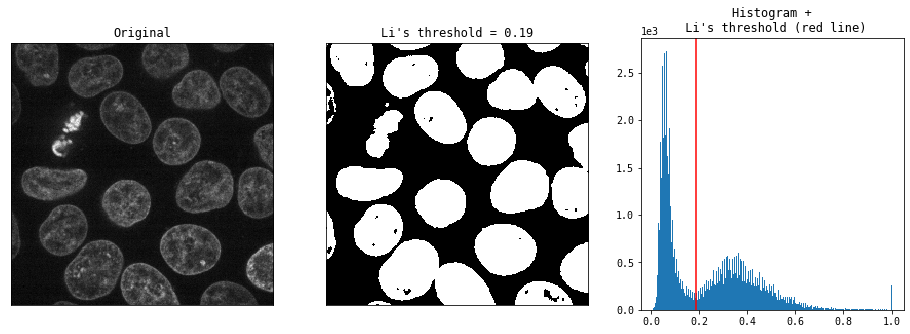

In [22]:
threshold_li = filters.threshold_li(plane_denoised)
plane_binary = plane_denoised >= threshold_li

_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

# Checking the results.
sc.show_plane(win_left, plane, title='Original')
sc.show_plane(win_center, plane_binary, title='Li\'s threshold = {:0.2}'.format(threshold_li))

sc.plot_hist(win_right, plane_denoised, 'Histogram +\n Li\'s threshold (red line)')
win_right.axvline(threshold_li, c='r')

<div class="alert alert-success">

__Exercise: <font color='red'>(⏰ 5 min)</font>__ There are lots of thresholding algorithms in scikit-image, and a function that helps you on trying some of them.

Your task is:
  * Use the function `filters.try_all_threshold` to try some different thresholds on our plane. Compare their results.
  * Check the threshold values of each algorithm contained in that function. The functions have names such as `filters.threshold_*`; start typing and use the ``TAB`` key to complete.

TypeError: Image data of dtype object cannot be converted to float

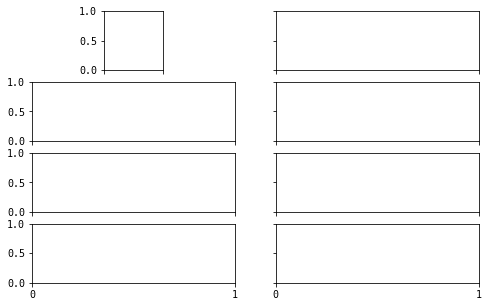

In [23]:
# Your solution goes here!
filters.try_all_threshold(...)

print(filters.threshold_isodata(plane_denoised))  # This one is for free!

## <a id='morphology'></a>[skimage.morphology](https://scikit-image.org/docs/stable/api/skimage.morphology.html) - binary and grayscale morphology

Morphological image processing is a collection of non-linear operations related to the shape or morphology of features in an image, such as boundaries, skeletons, etc. In any given technique, we probe an image with a small shape or template called a structuring element, which defines the region of interest or neighborhood around a pixel.

[Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) operations and structuring elements are defined in `skimage.morphology`. Structuring elements are shapes which define areas over which an operation is applied. The response to the filter indicates how well the neighborhood corresponds to the structuring element's shape.

There are a number of two and three dimensional structuring elements defined in `skimage.morphology`. Not all 2D structuring element have a 3D counterpart. The simplest and most commonly used structuring elements are the `disk`/`ball` and `square`/`cube`.

In [24]:
from skimage import morphology  # skimage's morphological submodules.

In [25]:
disk = morphology.disk(radius=5)
ball = morphology.ball(radius=5)
print('* "disk" shape: {}\n* "ball" shape: {}'.format(disk.shape, ball.shape))

* "disk" shape: (11, 11)
* "ball" shape: (11, 11, 11)


The most basic mathematical morphology operations are `dilation` and `erosion`. Dilation enlarges bright regions and shrinks dark regions. Erosion shrinks bright regions and enlarges dark regions. Other morphological operations are composed of `dilation` and `erosion`.

The `closing` of an image is defined as a `dilation` followed by an `erosion`. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features. Morphological `opening` on an image is defined as an `erosion` followed by a `dilation`. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks. This tends to “open” up (dark) gaps between (bright) features.

These operations in `skimage.morphology` are compatible with 3D images and structuring elements. A 2D structuring element cannot be applied to a 3D image, nor can a 3D structuring element be applied to a 2D image.

These four operations (`closing`, `dilation`, `erosion`, `opening`) have binary counterparts which are faster to compute than the grayscale algorithms.

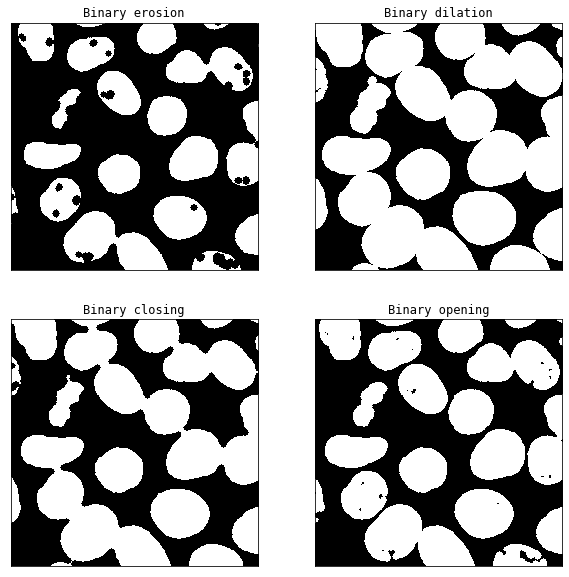

In [26]:
selem = morphology.disk(radius=3)

plane_binary_closing = morphology.binary_closing(plane_binary, selem=selem)
plane_binary_dilation = morphology.binary_dilation(plane_binary, selem=selem)
plane_binary_erosion = morphology.binary_erosion(plane_binary, selem=selem)
plane_binary_opening = morphology.binary_opening(plane_binary, selem=selem)

_, ((win_top_left, win_top_right),
    (win_bottom_left, win_bottom_right)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

sc.show_plane(win_top_left, plane_binary_erosion, title='Binary erosion')
sc.show_plane(win_top_right, plane_binary_dilation, title='Binary dilation')
sc.show_plane(win_bottom_left, plane_binary_closing, title='Binary closing')
sc.show_plane(win_bottom_right, plane_binary_opening, title='Binary opening')

Morphology operations can be chained together to denoise an image. For example, a `closing` applied to an `opening` can remove salt and pepper noise from an image.

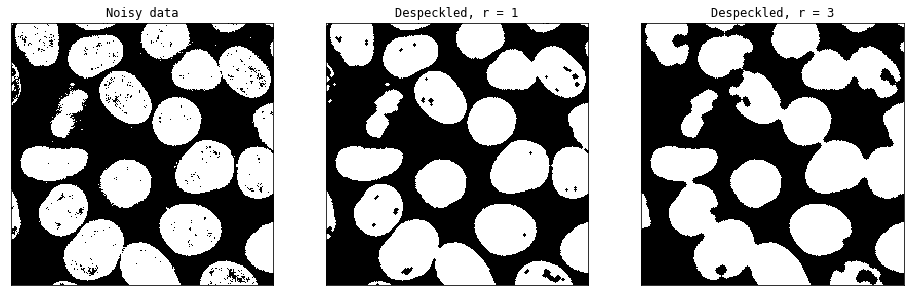

In [27]:
plane_binary_clipped = plane_rescaled >= filters.threshold_li(plane_clipped)

plane_despeckled_radius1 = morphology.closing(
    morphology.opening(plane_binary_clipped, selem=morphology.disk(1)),
    selem=morphology.disk(1)
)

plane_despeckled_radius3 = morphology.closing(
    morphology.opening(plane_binary_clipped, selem=morphology.disk(3)),
    selem=morphology.disk(3)
)

_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

sc.show_plane(win_left, plane_binary_clipped, title='Noisy data')
sc.show_plane(win_center, plane_despeckled_radius1, title='Despeckled, r = 1')
sc.show_plane(win_right, plane_despeckled_radius3, title='Despeckled, r = 3')

Functions operating on [connected components](https://en.wikipedia.org/wiki/Connected_space) can remove small undesired elements while preserving larger shapes.

`skimage.morphology.remove_small_holes` fills holes and `skimage.morphology.remove_small_objects` removes bright regions. Both functions accept a `min_size` parameter, which is the minimum size (in pixels) of accepted holes or objects. The `min_size` can be approximated by a cube.

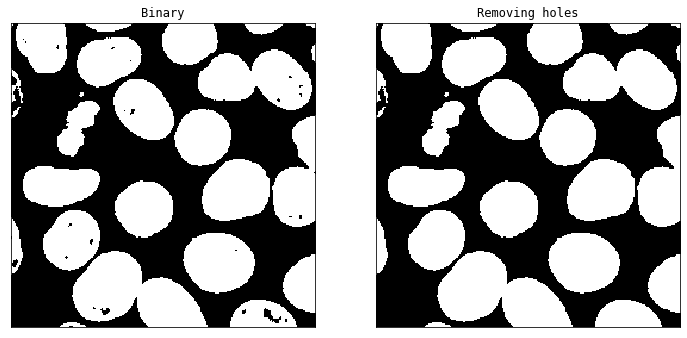

In [28]:
width = 20

plane_remove_holes = morphology.remove_small_holes(plane_binary,
                                                   width ** 3)

# Checking the results.
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane_binary, title='Binary');
sc.show_plane(win_right, plane_remove_holes, title='Removing holes')

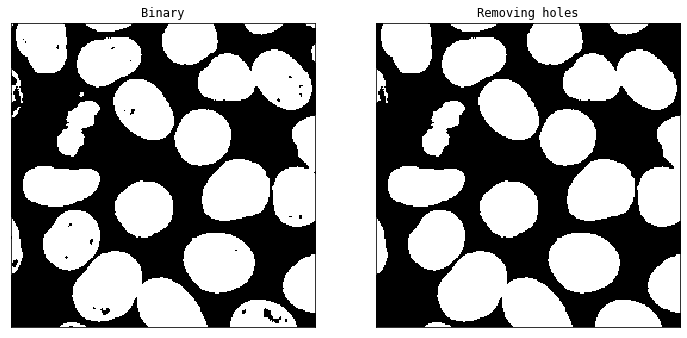

In [29]:
width = 50

plane_remove_objects = morphology.remove_small_objects(plane_remove_holes,
                                                       min_size=width)

# Checking the results.
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane_binary, title='Binary');
sc.show_plane(win_right, plane_remove_objects, title='Removing holes')

## <a id='measure'></a>[skimage.measure](https://scikit-image.org/docs/stable/api/skimage.measure.html) - measuring image or region properties

Multiple algorithms to label images, or obtain information about discrete regions of an image.

* `measure.label` - Label an image, i.e. identify discrete regions in the image using unique integers.
* `measure.regionprops` - In a labeled image, as returned by `label`, find various properties of the labeled regions.

Finding paths from a 2D image, or isosurfaces from a 3D image.

* `measure.find_contours`
* `measure.marching_cubes_lewiner`
* `measure.marching_cubes_classic`
* `measure.mesh_surface_area` - Surface area of 3D mesh from marching cubes.
* `measure.compare_*` - Quantify the difference between two whole images; often used in denoising or restoration.

**RANDom Sample Consensus fitting (RANSAC)** - a powerful, robust approach to fitting a model to data.  It exists here because its initial use was for fitting shapes, but it can also fit transforms.
* `measure.ransac`
* `measure.CircleModel`
* `measure.EllipseModel`
* `measure.LineModelND`

[Image segmentation](https://en.wikipedia.org/wiki/Image_segmentation) partitions images into regions of interest. Integer labels are assigned to each region to distinguish regions of interest.

Connected components of the binary image are assigned the same label via `skimage.measure.label`. Tightly packed cells  connected in the binary image are assigned the same label.

In [30]:
from skimage import measure  # skimage's measure submodule.

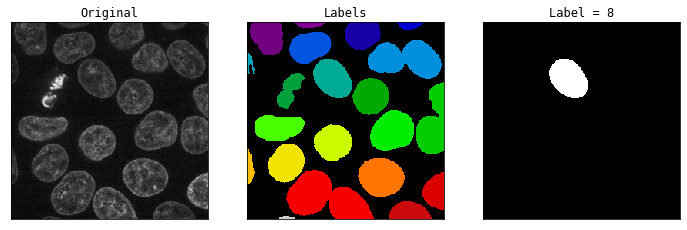

In [31]:
plane_labels = measure.label(plane_remove_objects)

# Checking the results.
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sc.show_plane(win_left, plane, title='Original')
sc.show_plane(win_center, plane_labels, cmap='nipy_spectral', title='Labels')
sc.show_plane(win_right, plane_labels == 8, title='Label = 8')

A better segmentation would assign different labels to disjoint regions in the original image. 

[Watershed segmentation](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) can distinguish touching objects. Markers are placed at local minima and expanded outward until there is a collision with markers from another region. The inverse intensity image transforms bright cell regions into basins which should be filled.

In declumping, markers are generated from the distance function. Points furthest from an edge have the highest intensity and should be identified as markers using `skimage.feature.peak_local_max`. Regions with pinch points should be assigned multiple markers.

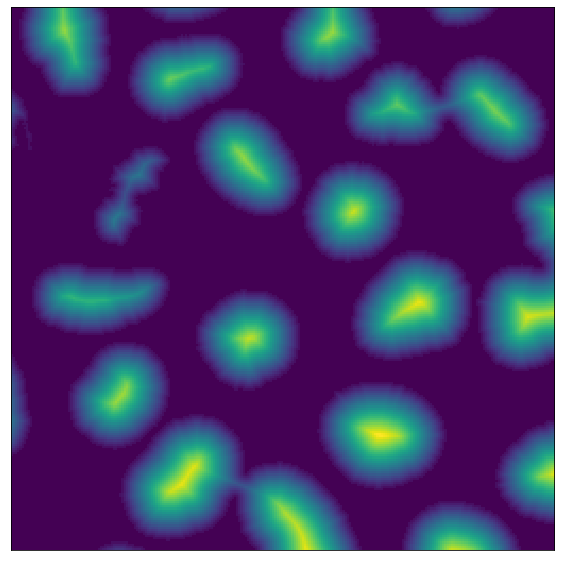

In [32]:
plane_distance = ndimage.distance_transform_edt(plane_remove_objects)

_, win = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sc.show_plane(win, plane_distance, cmap='viridis');

## [skimage.feature](https://scikit-image.org/docs/stable/api/skimage.feature.html) - extract features from an image<a id='feature'></a>

This submodule presents a diverse set of tools to identify or extract certain features from images, including tools for

* Edge detection: `feature.canny`
* Corner detection:
  * `feature.corner_kitchen_rosenfeld`
  * `feature.corner_harris`
  * `feature.corner_shi_tomasi`
  * `feature.corner_foerstner`
  * `feature.subpix`
  * `feature.corner_moravec`
  * `feature.corner_fast`
  * `feature.corner_orientations`
* Blob detection
  * `feature.blob_dog`
  * `feature.blob_doh`
  * `feature.blob_log`
* Texture
  * `feature.greycomatrix`
  * `feature.greycoprops`
  * `feature.local_binary_pattern`
  * `feature.multiblock_lbp`
* Peak finding: `feature.peak_local_max`
* Object detction
  * `feature.hog`
  * `feature.match_template`
* Stereoscopic depth estimation: `feature.daisy`
* Feature matching
  * `feature.ORB`
  * `feature.BRIEF`
  * `feature.CENSURE`
  * `feature.match_descriptors`
  * `feature.plot_matches`


In [33]:
from skimage import feature  # skimage's feature submodule.

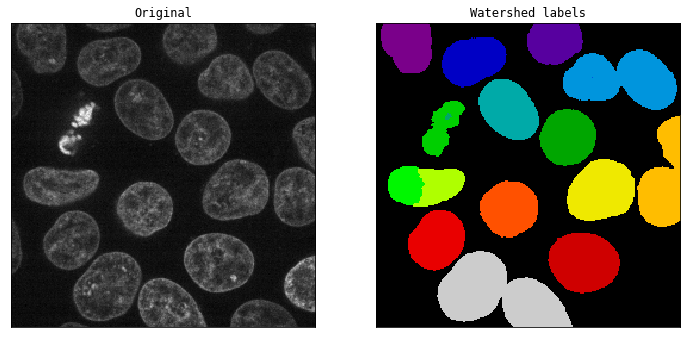

In [34]:
peak_local_max = feature.peak_local_max(
    plane_distance,
    footprint=np.ones((15, 15), dtype=np.bool),
    indices=False,
    labels=measure.label(plane_remove_objects)
)

plane_markers = measure.label(peak_local_max)

plane_labels = morphology.watershed(
    plane_rescaled, 
    plane_markers, 
    mask=plane_remove_objects
)

# Checking the results.
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane, title='Original')
sc.show_plane(win_right, plane_labels, cmap='nipy_spectral', title='Watershed labels')

After watershed, we have better disambiguation between internal cells.

The watershed algorithm falsely detected subregions in a few cells. This is referred to as oversegmentation.

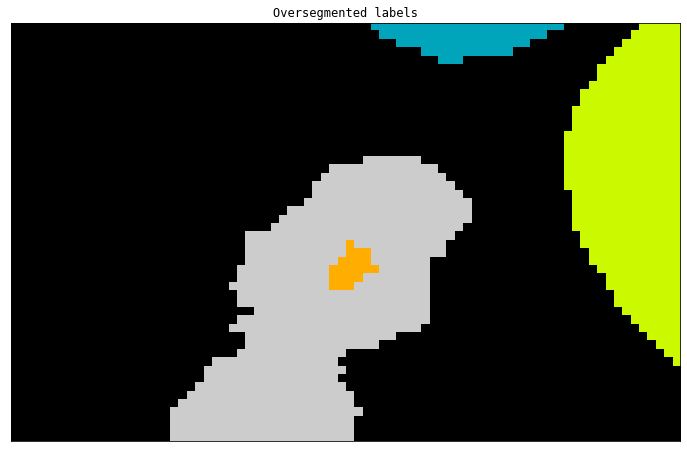

In [35]:
_, axis = plt.subplots(figsize=(12, 8))
sc.show_plane(axis, plane_labels[50:100, 20:100], cmap='nipy_spectral', title='Oversegmented labels')

Plotting the markers on the distance image reveals the reason for oversegmentation. Cells with multiple markers will be assigned multiple labels, and oversegmented. It can be observed that cells with a uniformly increasing distance map are assigned a single marker near their center. Cells with uneven distance maps are assigned multiple markers, indicating the presence of multiple local maxima.

[]

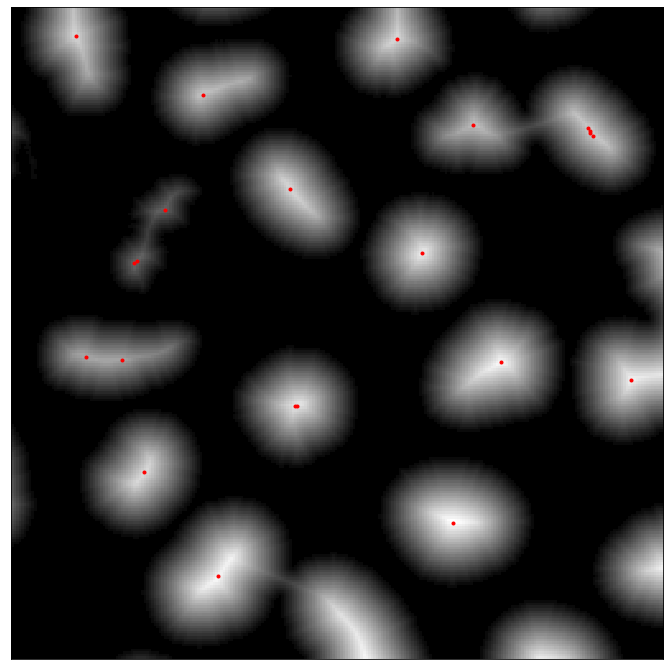

In [36]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))

vmin = plane_distance.min()
vmax = plane_distance.max()

ax.imshow(plane_distance, cmap='gray', vmin=vmin, vmax=vmax)
    
peaks = np.nonzero(peak_local_max)
    
ax.plot(peaks[1], peaks[0], 'r.')
ax.set_xticks([])
ax.set_yticks([])

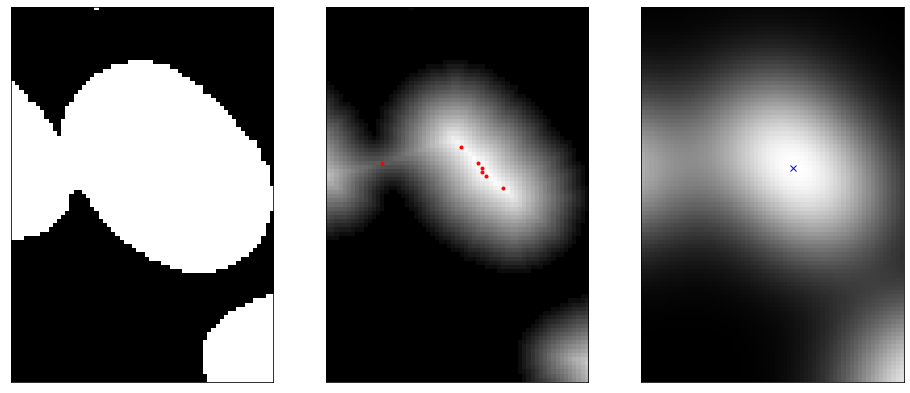

In [37]:
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

sc.show_plane(win_left, plane_remove_objects[10:100, 190:253])
sc.show_plane(win_center, plane_distance[10:100, 190:253])

features = feature.peak_local_max(plane_distance[10:100, 190:253])
win_center.plot(features[:, 1], features[:, 0], 'r.')

# Improve feature selection by blurring, using a larger footprint
# in `peak_local_max`, etc.

smooth_distance = filters.gaussian(plane_distance[10:100, 190:253], sigma=10)
sc.show_plane(win_right, smooth_distance)
features = feature.peak_local_max(
    smooth_distance
)
win_right.plot(features[:, 1], features[:, 0], 'bx');

In [51]:
peak_local_max = feature.peak_local_max(
    ,
    footprint=np.ones((15, 15, 15), dtype=np.bool),
    indices=False,
    labels=measure.label(remove_objects)
)

markers = measure.label(peak_local_max)

labels = morphology.watershed(
    rescaled, 
    markers, 
    mask=remove_objects
)

slice_explorer(labels, cmap='inferno');

NameError: name 'distance' is not defined

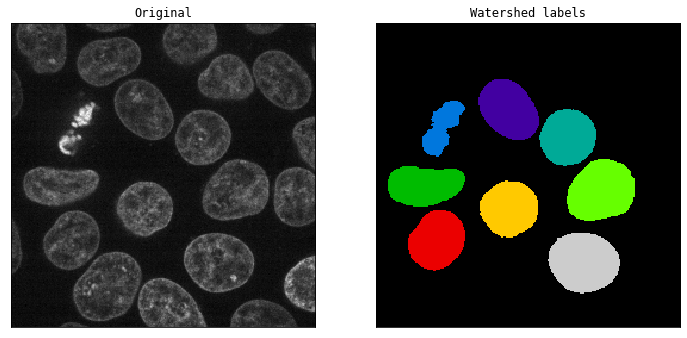

In [50]:
smooth_distance = filters.gaussian(plane_distance, sigma=10)
peak_local_max = feature.peak_local_max(
    smooth_distance,
    footprint=np.ones((75, 75), dtype=np.bool),
    indices=False,
    labels=measure.label(plane_remove_objects)
)

plane_markers = measure.label(peak_local_max)

plane_labels = morphology.watershed(
    plane_rescaled, 
    plane_markers, 
    mask=plane_remove_objects
)

# Checking the results.
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane, title='Original')
sc.show_plane(win_right, plane_labels, cmap='nipy_spectral', title='Watershed labels')

<div class="alert alert-success">

__Exercise: <font color='red'>(⏰ 5 min)</font>__ Please help me generate a better result!

Your task is:
  * Change `sigma` and `footprint` to generate a better segmentation.

In [39]:
smooth_distance = filters.gaussian(plane_distance, sigma=...)
peak_local_max = feature.peak_local_max(
    smooth_distance,
    footprint=np.ones(..., dtype=np.bool),
    indices=False,
    labels=measure.label(plane_remove_objects)
)

plane_markers = measure.label(peak_local_max)

plane_labels = morphology.watershed(
    plane_rescaled, 
    plane_markers, 
    mask=plane_remove_objects
)

# Checking the results.
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane, title='Original')
sc.show_plane(win_right, plane_labels, cmap='nipy_spectral', title='Watershed labels')

TypeError: '<' not supported between instances of 'ellipsis' and 'float'

## <a id='segmentation'></a>[skimage.segmentation](https://scikit-image.org/docs/stable/api/skimage.segmentation.html) - identification of regions of interest

One of the key image analysis tasks is identifying regions of interest.  These could be a person, an object, certain features of an animal, microscopic image, or stars.  Segmenting an image is the process of determining where these things you want are in your images.

Segmentation has two overarching categories:

**Supervised** - must provide some guidance (seed points or initial conditions)

* `segmentation.random_walker`
* `segmentation.active_contour`
* `segmentation.watershed`
* `segmentation.flood_fill`
* `segmentation.flood`

**Unsupervised** - no human input

* `segmentation.slic`
* `segmentation.felzenszwalb`
* `segmentation.chan_vese`

There are also some supervised and unsupervised thresholding algorithms in `filters`. There is a [segmentation lecture](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/4_segmentation.ipynb) ([and its solution](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/4_segmentation.ipynb)) you may peruse, as well as many [gallery examples](https://scikit-image.org/docs/stable/auto_examples/index.html#segmentation-of-objects) which illustrate all of these segmentation methods.

[Feature extraction](https://en.wikipedia.org/wiki/Feature_extraction) reduces data required to describe an image or objects by measuring informative features. These include features such as area or volume, bounding boxes, and intensity statistics.

Before measuring objects, it helps to clear objects from the image border. Measurements should only be collected for objects entirely contained in the image.

In [40]:
from skimage import segmentation  # skimage's segmentation submodule.

Interior labels: [ 0  3  4  5  6  7  8  9 10 11 12 13]


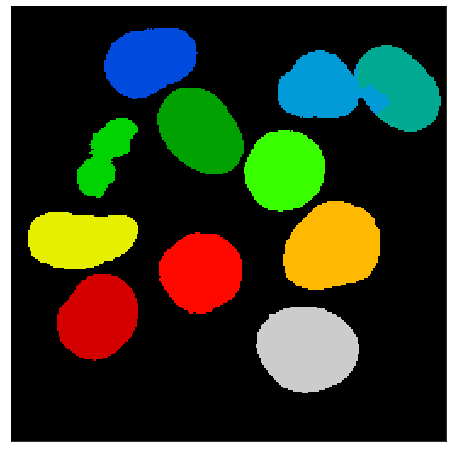

In [41]:
plane_labels_inner = segmentation.clear_border(plane_labels)
plane_labels_inner = morphology.remove_small_objects(plane_labels_inner, min_size=200)

print('Interior labels: {}'.format(np.unique(plane_labels_inner)))

_, axis = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sc.show_plane(axis, plane_labels_inner, cmap='nipy_spectral');

After clearing the border, the object labels are no longer sequentially increasing. The labels can be renumbered such that there are no jumps in the list of image labels:

In [42]:
plane_relabeled, _, _ = segmentation.relabel_sequential(plane_labels_inner)

print('Relabeled labels: {}'.format(np.unique(plane_relabeled)))

Relabeled labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]


`skimage.measure.regionprops` automatically measures many labeled image features. Optionally, an `intensity_image` can be supplied and intensity features are extracted per object. It's good practice to make measurements on the original image.

The list below shows supported 2D measurements.

In [43]:
properties = measure.regionprops(plane_relabeled, intensity_image=plane)
props_first_region = properties[0]

supported = [''] 

for prop in props_first_region:
    try:
        props_first_region[prop]
        supported.append(prop)
    except NotImplementedError:
        pass

print('Supported 2D properties:')
print('\n\t'.join(supported))

Supported 2D properties:

	area
	bbox
	bbox_area
	centroid
	convex_area
	convex_image
	coords
	eccentricity
	equivalent_diameter
	euler_number
	extent
	filled_area
	filled_image
	image
	inertia_tensor
	inertia_tensor_eigvals
	intensity_image
	label
	local_centroid
	major_axis_length
	max_intensity
	mean_intensity
	min_intensity
	minor_axis_length
	moments
	moments_central
	moments_hu
	moments_normalized
	orientation
	perimeter
	slice
	solidity
	weighted_centroid
	weighted_local_centroid
	weighted_moments
	weighted_moments_central
	weighted_moments_hu
	weighted_moments_normalized


`skimage.measure.regionprops` ignores the 0 label, which represents the background.

In [44]:
print('Measured regions: {}'.format([prop.label for prop in properties]))

Measured regions: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [45]:
plane_areas = [prop.area for prop in properties]

print('Total pixels: {}'.format(plane_areas))

Total pixels: [1717, 1679, 1637, 1914, 887, 1776, 1753, 2320, 1795, 1837, 2381]


Collected measurements can be further reduced by computing per-image statistics such as total, minimum, maximum, mean, and standard deviation.

In [46]:
print('Area statistics\n')
print(' * Total: {}'.format(np.sum(plane_areas)))
print(' * Min: {}'.format(np.min(plane_areas)))
print(' * Max: {}'.format(np.max(plane_areas)))
print(' * Mean: {:0.2f}'.format(np.mean(plane_areas)))
print(' * Standard deviation: {:0.2f}'.format(np.std(plane_areas)))

Area statistics

 * Total: 19696
 * Min: 887
 * Max: 2381
 * Mean: 1790.55
 * Standard deviation: 369.99


<div class="alert alert-success">

__Exercise: <font color='red'>(⏰ 5 min)</font>__ Let's check other properties.

Your task is:
  * Use `regionprops` and check other properties for the labeled regions. Some examples: `centroid` and `equivalent_diameter`.

## Going beyond

[1] A tour/guide on scikit-image's submodules: https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/tour_of_skimage.ipynb

[2] scikit-image's gallery examples: https://scikit-image.org/docs/stable/auto_examples/